#####**Quiin Latifah Almatin Lubis (21.11.4069)**

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import string
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import pickle

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/skripsi/data market indo/dataset/2017_2024.csv")
data.head()

,track,artist,popularity,lyrics
0,"Untungnya, Hidup Harus Tetap Berjalan",Bernadya,84,Persis setahun yang lalu\nKu dijauhkan dari ya...
1,Kata Mereka Ini Berlebihan,Bernadya,81,Ku tak pernah ikat rambutku lagi semenjak kaub...
2,Lama-Lama,Bernadya,81,Berusaha tetap terjaga\nTunggu kamu selesaikan...
3,Kini Mereka Tahu,Bernadya,79,Dari dulu kulebih-lebihkan semua\nPadahal yang...
4,Mati-Matian,Mahalini,78,Mahalini baru saaja merilis lagu terbarunya ya...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652 entries, 0 to 651
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   track       652 non-null    object
 1   artist      652 non-null    object
 2   popularity  652 non-null    int64 
 3   lyrics      652 non-null    object
dtypes: int64(1), object(3)
memory usage: 20.5+ KB


In [ ]:
data.isna().sum()

,0
track,0
artist,0
popularity,0
lyrics,0


In [ ]:
print(data.duplicated().sum())

0


In [ ]:
#Menghitung Rekapitulasi Popularity
data['popularity'].value_counts().sort_index(ascending=True)

,count
popularity,
1,1
10,1
14,1
30,1
33,1
34,5
35,4
36,13
37,15


In [ ]:
data.describe()

,popularity
count,652.000000
mean,51.558282
std,11.505745
min,1.000000
25%,43.000000
50%,49.000000
75%,59.000000
max,84.000000


In [ ]:
#Kolom sentimen
sentimen = []
for index, row in data.iterrows():
  if row['popularity'] < 43:
    sentimen.append('kurang populer')
  elif row['popularity'] < 59:
    sentimen.append('lumayan populer')
  else:
    sentimen.append('sangat populer')

data['sentiment'] = sentimen

In [ ]:
data.head()

,track,artist,popularity,lyrics,sentiment
0,"Untungnya, Hidup Harus Tetap Berjalan",Bernadya,84,Persis setahun yang lalu\nKu dijauhkan dari ya...,sangat populer
1,Kata Mereka Ini Berlebihan,Bernadya,81,Ku tak pernah ikat rambutku lagi semenjak kaub...,sangat populer
2,Lama-Lama,Bernadya,81,Berusaha tetap terjaga\nTunggu kamu selesaikan...,sangat populer
3,Kini Mereka Tahu,Bernadya,79,Dari dulu kulebih-lebihkan semua\nPadahal yang...,sangat populer
4,Mati-Matian,Mahalini,78,Mahalini baru saaja merilis lagu terbarunya ya...,sangat populer


In [ ]:
sentiment_counts = data['sentiment'].value_counts()
print(sentiment_counts)

sentiment
lumayan populer    338
sangat populer     166
kurang populer     148
Name: count, dtype: int64


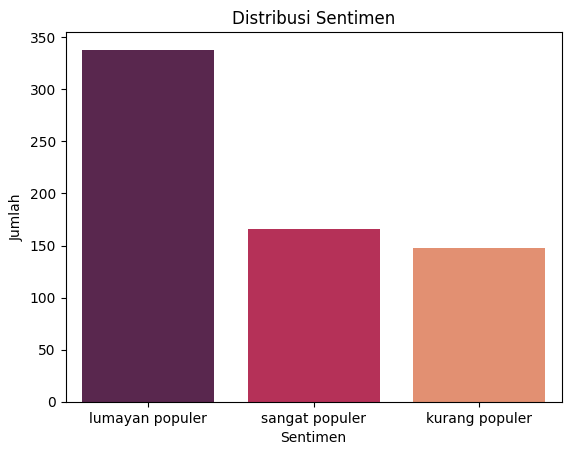

In [ ]:
# Hitung jumlah data untuk setiap kategori sentimen
sentiment_counts = data['sentiment'].value_counts()

# Plot distribusi sentimen
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, hue=sentiment_counts.index, palette="rocket", dodge=False)

# Tambahkan judul dan label sumbu
plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')

# Tampilkan plot
plt.show()

#Cleaning

In [ ]:
# Fungsi untuk memeriksa apakah baris pertama berisi promosi atau deskripsi
def is_promotional_line(line):
    promotional_keywords = [
        "merilis", "dapat mewakili perasaan", "jangan berlarut", "merupakan", "yang dirilis pada tahun",
        "intip liriknya", "yuk simak lirik lagunya", "lagu tersebut dapat disaksikan di channel youtube",
        "sudah tahu yang ini belum?"
    ]
    return any(keyword in line.lower() for keyword in promotional_keywords)

# Fungsi untuk membersihkan lirik dari deskripsi atau promosi
def clean_lyrics(lyrics):
    # Pisahkan lirik menjadi baris-baris
    lines = lyrics.splitlines()

    # Cek apakah baris pertama merupakan deskripsi atau promosi dan hapus jika ya
    if lines and is_promotional_line(lines[0]):
        lines.pop(0)  # Hapus baris pertama jika merupakan promosi

    for i, line in enumerate(lines):
        if "sudah tahu yang ini belum?" in line.lower():
            lines = lines[:i]

    # Gabungkan kembali baris-baris menjadi teks lirik
    text = "\n".join(lines)

    promo_keywords = [
        "sudah tahu yang ini belum?",
    ]

    for keyword in promo_keywords:
        if keyword.lower() in text.lower():
            text = text.split(keyword.lower())[0].strip()

    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r"\b(?:verse|chorus|bridge|coda|chorus to coda|records|back to reff|kembali ke reff)\b", "", text, flags=re.IGNORECASE)
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text)

    # Menghapus spasi berlebih di awal dan akhir
    text = text.strip()
    return text
# Terapkan fungsi pembersihan ke kolom 'lyrics'
data['lyrics_clean'] = data['lyrics'].astype(str).apply(clean_lyrics)

In [ ]:
data.head()

,track,artist,popularity,lyrics,sentiment,lyrics_clean
0,"Untungnya, Hidup Harus Tetap Berjalan",Bernadya,84,Persis setahun yang lalu\nKu dijauhkan dari ya...,sangat populer,persis setahun yang lalu ku dijauhkan dari yan...
1,Kata Mereka Ini Berlebihan,Bernadya,81,Ku tak pernah ikat rambutku lagi semenjak kaub...,sangat populer,ku tak pernah ikat rambutku lagi semenjak kaub...
2,Lama-Lama,Bernadya,81,Berusaha tetap terjaga\nTunggu kamu selesaikan...,sangat populer,berusaha tetap terjaga tunggu kamu selesaikan ...
3,Kini Mereka Tahu,Bernadya,79,Dari dulu kulebih-lebihkan semua\nPadahal yang...,sangat populer,dari dulu kulebihlebihkan semua padahal yang k...
4,Mati-Matian,Mahalini,78,Mahalini baru saaja merilis lagu terbarunya ya...,sangat populer,kita adalah dua insan penuh cinta di awal terc...


In [ ]:
print(data['lyrics_clean'].iloc[4])

kita adalah dua insan penuh cinta di awal tercipta kisah kita manis tuturmu buatku terpana bagiku kau sempurna memang benar semua kata mereka benarku tlah dibutakan cinta tak hanya sekali kau khianati sudah cukup ku tak tahan lagi matimatian ku membelamu di depan mereka walau sakit tetap kupercaya kau beda dari lainnya habishabisan ku dibohongi sayang ini tetap sama tuhan ini cinta atau bodoh habis fikir dengan sifatmu itu berulangkali ku maafkan berulang lagi kau lakukan satu satunya kebanggaanku kini jadi rasa sakit terdalam to matimatian ku membelamu di depan mereka matimatian ku membelamu di depan mereka walau sakit tetap kupercaya kau beda dari lainnya habishabisan ku dibohongi sayang ini tetap sama tuhan ini cinta atau bodoh matimatian ku membelamu di depan mereka walau sakit tetap kupercaya kau beda dari lainnya habishabisan ku dibohongi sayang ini tetap sama tuhan ini cinta atau bodoh tuhan ini cinta atau bodoh


In [ ]:
data.dtypes

,0
track,object
artist,object
popularity,int64
lyrics,object
sentiment,object
lyrics_clean,object


In [ ]:
data['lyrics_clean'] = data['lyrics_clean'].astype('str')
data['lyrics_clean'] = data['lyrics_clean'].astype(pd.StringDtype())
data.dtypes

,0
track,object
artist,object
popularity,int64
lyrics,object
sentiment,object
lyrics_clean,string[python]


In [ ]:
#data.to_csv('/content/drive/MyDrive/skripsi/data market indo/dataset/indo_17-24_clean.csv', index=False)

##TF-IDF

In [ ]:
X = data['lyrics_clean']
y = data['sentiment']
vectorizer = TfidfVectorizer()
X_final = vectorizer.fit_transform(X)
print(X_final)

  (0, 6206)	0.07052761191200128
  (0, 7253)	0.0673489120340327
  (0, 8610)	0.12840842333069474
  (0, 3864)	0.03742671782007375
  (0, 3493)	0.08246216634879858
  (0, 1604)	0.07500773776301332
  (0, 1391)	0.02922879249559284
  (0, 7589)	0.04108216346726508
  (0, 1787)	0.0673489120340327
  (0, 8407)	0.04247360122820692
  (0, 3599)	0.06488332085802766
  (0, 6686)	0.028631384849752372
  (0, 2632)	0.05953578418218627
  (0, 3622)	0.06488332085802766
  (0, 2274)	0.02598451764831235
  (0, 4811)	0.07500773776301332
  (0, 201)	0.07052761191200128
  (0, 3951)	0.07176487843262785
  (0, 6124)	0.040605417698042344
  (0, 1205)	0.07500773776301332
  (0, 6264)	0.16052008696673448
  (0, 6426)	0.06286878618302066
  (0, 6558)	0.06116552138455878
  (0, 6797)	0.04956566940006642
  (0, 4151)	0.06286878618302066
  :	:
  (651, 3932)	0.0692158189847196
  (651, 508)	0.0692158189847196
  (651, 4767)	0.15967518616315704
  (651, 746)	0.14501520097178003
  (651, 1472)	0.21227571511558843
  (651, 2042)	0.0798375930815

In [ ]:
pickle.dump(vectorizer, open("/content/drive/MyDrive/skripsi/data market indo/code/Vectorizer.pkl", "wb"))

##Handling Imbalance

In [ ]:
# Handling imbalanced using SMOTE
smote = SMOTE()
x_sm, y_sm = smote.fit_resample(X_final, y)

In [ ]:
# Hitung jumlah sampel untuk setiap kelas
jumlah_kelas = y_sm.value_counts()

# Cetak jumlah sampel untuk setiap kelas
print("Jumlah sampel untuk setiap kelas:")
print(jumlah_kelas)

Jumlah sampel untuk setiap kelas:
sentiment
sangat populer     338
lumayan populer    338
kurang populer     338
Name: count, dtype: int64


<ipython-input-22-fbd5a2711fb5>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_sm, palette="rocket")


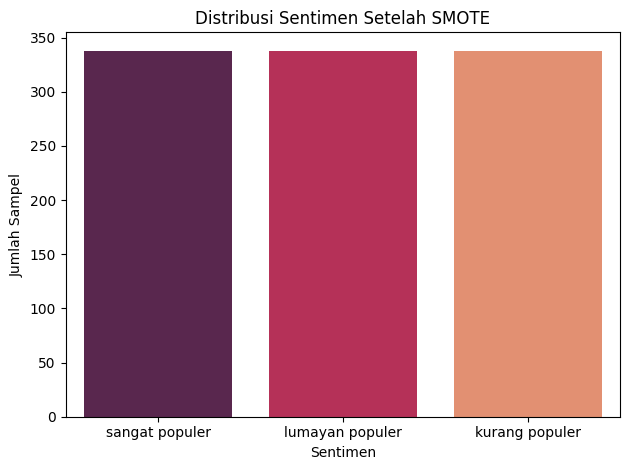

In [ ]:
sns.countplot(x=y_sm, palette="rocket")
plt.title('Distribusi Sentimen Setelah SMOTE')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Sampel')
plt.tight_layout()
plt.show()

##Split Data

In [ ]:
# Split data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(x_sm, y_sm, test_size=0.2, shuffle=True)

In [ ]:
print(f'Jumlah data pada X_train: {X_train.shape[0]}')
print(f'Jumlah data pada X_test: {X_test.shape[0]}')

Jumlah data pada X_train: 811
Jumlah data pada X_test: 203


##Modelling

In [ ]:
# Inisialisasi model SVM
model = OneVsRestClassifier(SVC())

# Latih model SVM menggunakan data latih
model.fit(X_train, y_train)

# Prediksi kelas menggunakan data uji
y_pred = model.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)

# Cetak hasil evaluasi
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8423645320197044

Classification Report:
                  precision    recall  f1-score   support

 kurang populer       0.98      0.76      0.85        66
lumayan populer       0.71      0.97      0.82        66
 sangat populer       0.92      0.80      0.86        71

       accuracy                           0.84       203
      macro avg       0.87      0.84      0.84       203
   weighted avg       0.87      0.84      0.84       203



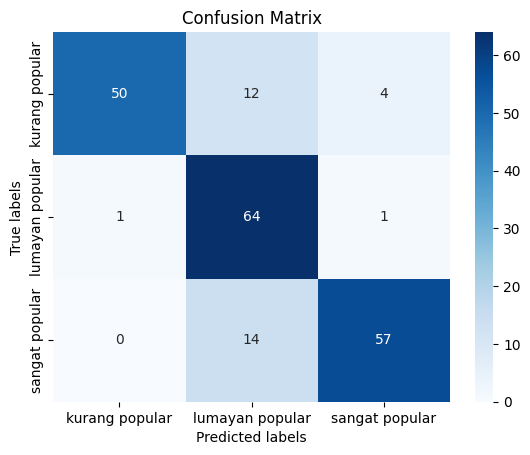

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
labels = ['kurang popular', 'lumayan popular', 'sangat popular']

# Membuat heatmap untuk visualisasi confusion matrix dengan label yang sesuai
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

# Menampilkan skor untuk setiap fold
print("Skor setiap fold:", cv_scores)

# Menghitung rata-rata dan standar deviasi dari skor
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

# Menampilkan hasil
print("Rata-rata skor cross-validation: %.2f%%" % (mean_cv_score * 100))
print("Standar deviasi skor cross-validation: %.2f%%" % (std_cv_score * 100))

Skor setiap fold: [0.82208589 0.82098765 0.84567901 0.83333333 0.85185185]
Rata-rata skor cross-validation: 83.48%
Standar deviasi skor cross-validation: 1.24%


#Hyperparamater Tuning dengan GridSearchCV

In [ ]:
parameter = {
    'estimator__kernel': ['linear', 'rbf', 'poly'],
    'estimator__C': [0.01, 0.1, 1, 5, 10, 25, 50, 100],
    'estimator__gamma': ['auto', 'scale', 1, 0.1, 0.01, 0.001],
}

clf = GridSearchCV(estimator=model, param_grid=parameter, cv=5, scoring='accuracy', verbose=1)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=SVC()),
             param_grid={'estimator__C': [0.01, 0.1, 1, 5, 10, 25, 50, 100],
                         'estimator__gamma': ['auto', 'scale', 1, 0.1, 0.01,
                                              0.001],
                         'estimator__kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=1)

In [ ]:
#Evaluasi performa GridSearch
print("\nEvaluasi Semua Percobaan:")
for mean, std, params in zip(clf.cv_results_['mean_test_score'],
                             clf.cv_results_['std_test_score'],
                             clf.cv_results_['params']):
    print(f"Parameter: {params}, Mean Accuracy: {mean:.3f}, Std: {std:.3f}")

print("\nBest Parameters:", clf.best_params_)
print("Best Cross-Validation Score:", clf.best_score_)


Evaluasi Semua Percobaan:
Parameter: {'estimator__C': 0.01, 'estimator__gamma': 'auto', 'estimator__kernel': 'linear'}, Mean Accuracy: 0.726, Std: 0.022
Parameter: {'estimator__C': 0.01, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf'}, Mean Accuracy: 0.726, Std: 0.024
Parameter: {'estimator__C': 0.01, 'estimator__gamma': 'auto', 'estimator__kernel': 'poly'}, Mean Accuracy: 0.755, Std: 0.034
Parameter: {'estimator__C': 0.01, 'estimator__gamma': 'scale', 'estimator__kernel': 'linear'}, Mean Accuracy: 0.726, Std: 0.022
Parameter: {'estimator__C': 0.01, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'}, Mean Accuracy: 0.814, Std: 0.021
Parameter: {'estimator__C': 0.01, 'estimator__gamma': 'scale', 'estimator__kernel': 'poly'}, Mean Accuracy: 0.666, Std: 0.025
Parameter: {'estimator__C': 0.01, 'estimator__gamma': 1, 'estimator__kernel': 'linear'}, Mean Accuracy: 0.726, Std: 0.022
Parameter: {'estimator__C': 0.01, 'estimator__gamma': 1, 'estimator__kernel': 'rbf'}, Mean Accur

In [ ]:
# Model terbaik dari GridSearchCV
best_model = clf.best_estimator_

# Latih model terbaik dengan data train
best_model.fit(X_train, y_train)

# Prediksi pada data test
y_pred_tuned = best_model.predict(X_test)

# Evaluasi model hasil tuning
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print("Accuracy (Tuned Model):", accuracy_tuned)
print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred_tuned))

Accuracy (Tuned Model): 0.8866995073891626

Classification Report (Tuned Model):
                 precision    recall  f1-score   support

 kurang populer       0.98      0.85      0.91        66
lumayan populer       0.79      0.95      0.86        66
 sangat populer       0.92      0.86      0.89        71

       accuracy                           0.89       203
      macro avg       0.90      0.89      0.89       203
   weighted avg       0.90      0.89      0.89       203



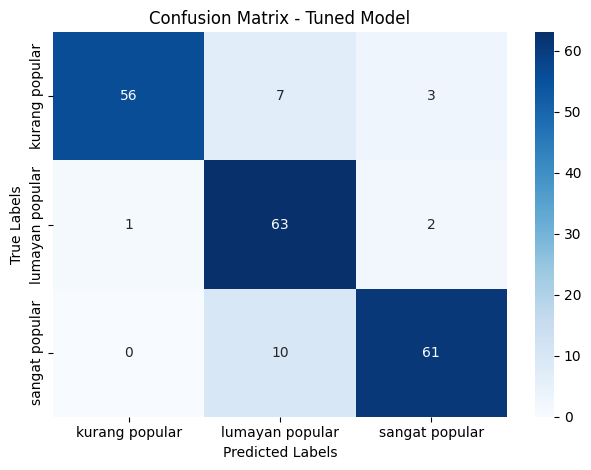

In [ ]:
labels = ['kurang popular', 'lumayan popular', 'sangat popular']
conf_matrix = confusion_matrix(y_test, y_pred_tuned)

sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Tuned Model')
plt.tight_layout()
plt.show()

In [ ]:
# Cross-validation untuk model hasil tuning
cv_scores_tuned = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')

# Menampilkan hasil
print("\nCross-Validation Scores (Tuned Model):", cv_scores_tuned)
print("Mean CV Score (Tuned Model): %.2f%%" % (np.mean(cv_scores_tuned) * 100))
print("Standard Deviation (Tuned Model): %.2f%%" % (np.std(cv_scores_tuned) * 100))


Cross-Validation Scores (Tuned Model): [0.85276074 0.86419753 0.85185185 0.87654321 0.86419753]
Mean CV Score (Tuned Model): 86.19%
Standard Deviation (Tuned Model): 0.90%


In [ ]:
#Perbandingan Sebelum dan Sesudah Tuning
print("\n=== Perbandingan Kinerja Sebelum dan Sesudah Tuning ===")
print(f"Accuracy Sebelum Tuning: {accuracy:.4f}")
print(f"Accuracy Sesudah Tuning: {accuracy_tuned:.4f}")
print(f"Mean CV Score Sebelum Tuning: {np.mean(cv_scores):.4f}")
print(f"Mean CV Score Sesudah Tuning: {np.mean(cv_scores_tuned):.4f}")


=== Perbandingan Kinerja Sebelum dan Sesudah Tuning ===
Accuracy Sebelum Tuning: 0.8424
Accuracy Sesudah Tuning: 0.8867
Mean CV Score Sebelum Tuning: 0.8348
Mean CV Score Sesudah Tuning: 0.8619


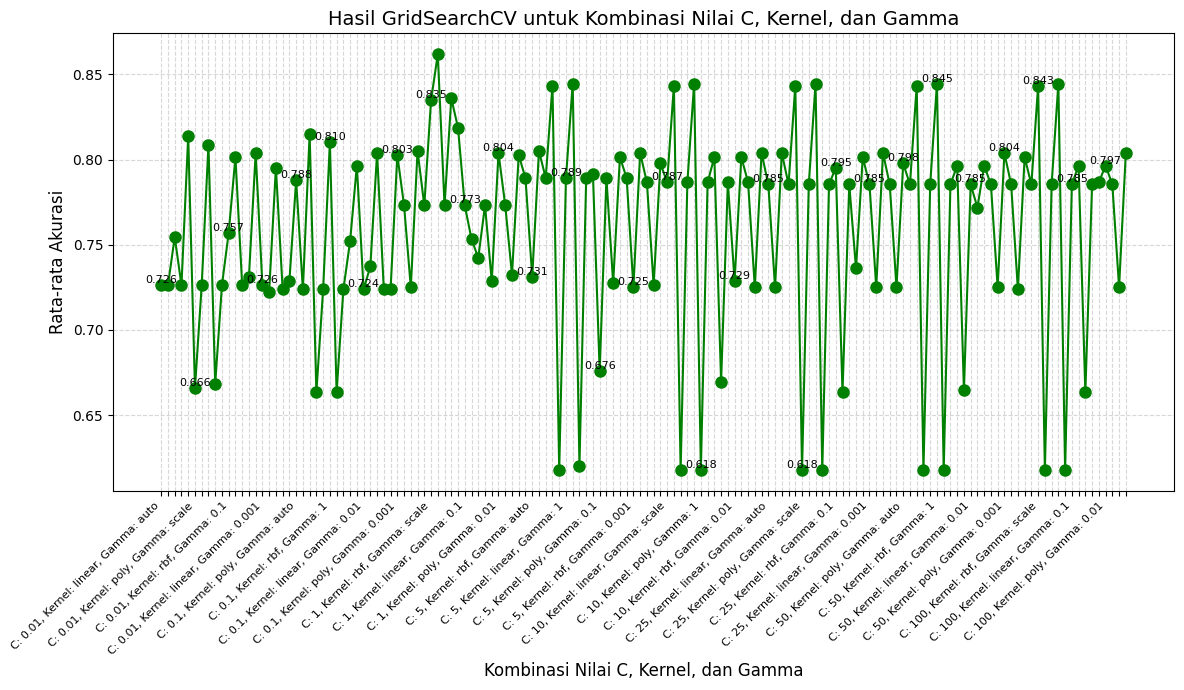

In [ ]:
# Ekstrak hasil grid search
mean_scores = clf.cv_results_['mean_test_score']
std_scores = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']

# Buat label kombinasi C, kernel, dan gamma
combinations = [f'C: {param["estimator__C"]}, Kernel: {param["estimator__kernel"]}, Gamma: {param["estimator__gamma"]}' for param in params]

# Perbesar ukuran plot
plt.figure(figsize=(12, 7))

# Plot garis dengan titik yang lebih jelas
plt.plot(range(len(combinations)), mean_scores, linestyle='-', marker='o', color='green', markersize=8, linewidth=1.5)

# Tambahkan label nilai mean akurasi setiap beberapa titik
step = max(1, len(combinations) // 25)
for i in range(0, len(mean_scores), step):
    plt.text(i, mean_scores[i], f'{mean_scores[i]:.3f}', ha='center', va='bottom', fontsize=8, color='black')

# Filter dan atur label sumbu X
x_labels = [combinations[i] if i % step == 0 else '' for i in range(len(combinations))]
plt.xticks(range(len(combinations)), x_labels, rotation=45, ha='right', fontsize=8)

# Tambahkan grid untuk membantu analisis
plt.grid(True, linestyle='--', alpha=0.5)

# Label sumbu dan judul
plt.xlabel('Kombinasi Nilai C, Kernel, dan Gamma', fontsize=12)
plt.ylabel('Rata-rata Akurasi', fontsize=12)
plt.title('Hasil GridSearchCV untuk Kombinasi Nilai C, Kernel, dan Gamma', fontsize=14)

# Layout rapi
plt.tight_layout()
plt.show()

In [ ]:
filename = '/content/drive/MyDrive/skripsi/data market indo/code/predict_lirik.pkl'
pickle.dump(clf, open(filename, 'wb'))

#WORDCLOUD

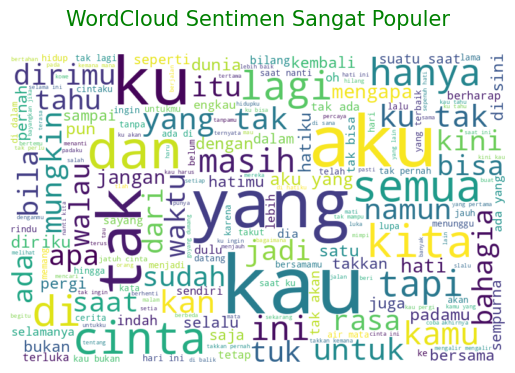

In [ ]:
# Filter dataFrame untuk sentimen sangat populer
data_popular = data[data['sentiment'] == 'sangat populer']

# Gabungkan semua teks dalam kolom 'lyrics_clean' untuk sentimen sangat popular
all_words_popular = ' '.join(data_popular['lyrics_clean'])

# Buat WordCloud untuk sentimen sangat popular
wordcloud_popular = WordCloud(background_color='white', width=800, height=500, random_state=21, max_font_size=130, colormap='viridis').generate(all_words_popular)

# Tampilkan WordCloud
plt.imshow(wordcloud_popular, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Sentimen Sangat Populer', fontsize=15, pad=20, color='green')
plt.show()

<ipython-input-45-993bb5eb399f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


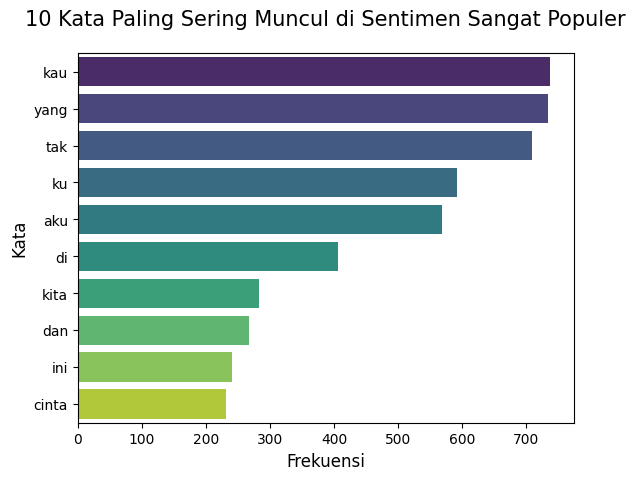

In [ ]:
word_freq = Counter(all_words_popular.split())
most_common_words = word_freq.most_common(10)

words, counts = zip(*most_common_words)
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.title('10 Kata Paling Sering Muncul di Sentimen Sangat Populer', fontsize=15, pad=20)
plt.xlabel('Frekuensi', fontsize=12)
plt.ylabel('Kata', fontsize=12)
plt.show()

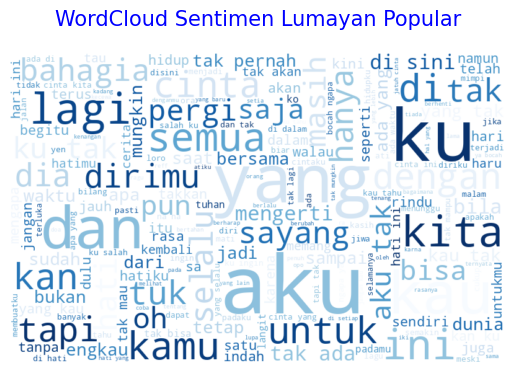

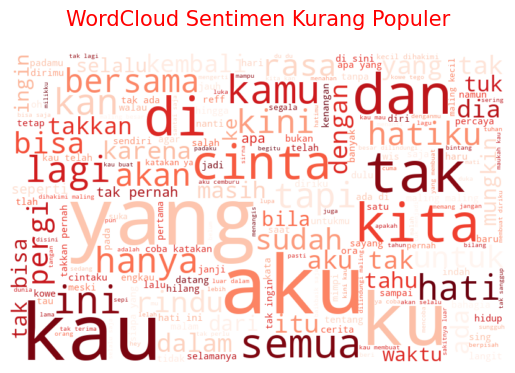

In [ ]:
# Filter DataFrame untuk sentimen lumayan popular
data_moderate = data[data['sentiment'] == 'lumayan populer']

# Filter DataFrame untuk sentimen Kurang populer
data_not_popular = data[data['sentiment'] == 'kurang populer']

# Gabungkan semua teks dalam kolom 'lyrics_clean' untuk sentimen lumayan popular
all_words_moderate = ' '.join(data_moderate['lyrics_clean'])

# Gabungkan semua teks dalam kolom 'lyrics_clean' untuk sentimen Kurang populer
all_words_not_popular = ' '.join(data_not_popular['lyrics_clean'])

# Buat WordCloud untuk sentimen sedang dengan warna biru
wordcloud_moderate = WordCloud(background_color='white', width=800, height=500, random_state=21, max_font_size=130, colormap='Blues').generate(all_words_moderate)

# Buat WordCloud untuk sentimen Kurang populer dengan warna merah
wordcloud_not_popular = WordCloud(background_color='white', width=800, height=500, random_state=21, max_font_size=130, colormap='Reds').generate(all_words_not_popular)

plt.imshow(wordcloud_moderate, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Sentimen Lumayan Popular', fontsize=15, pad=20, color='blue')
plt.show()

# Tampilkan WordCloud untuk sentimen kurang populer
plt.imshow(wordcloud_not_popular, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Sentimen Kurang Populer', fontsize=15, pad=20, color='red')
plt.show()